<a href="https://colab.research.google.com/github/SVJLucas/IsVoldemortAGorilla/blob/main/code/CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.8 MB/s eta 0:00:00


In [2]:
import os
import cv2
import glob
import shap
import torch
import numpy as np
import torchvision
from torch import nn
from PIL import Image
from torch.optim import Adam
from shap.plots import colors
import matplotlib.pyplot as plt
from shap.utils._legacy import kmeans
from torch.nn.functional import softmax
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
from torchvision.models import resnet50,ResNet50_Weights
#from transformers import DinoModel, DinoProcessor
from transformers import CLIPModel, CLIPProcessor
from transformers import ViTFeatureExtractor, ViTForImageClassification

In [3]:
# Set up the Kaggle configuration
import os
import json

# Make directory to store Kaggle API key
os.makedirs('/root/.kaggle/', exist_ok=True)

# Move kaggle.json file to the directory
!mv kaggle.json /root/.kaggle/

# Change the permissions of the file
os.chmod('/root/.kaggle/kaggle.json', 600)

# Download the dataset
!kaggle datasets download -d jessicali9530/caltech256

# Unzip the dataset
!unzip caltech256.zip

Streaming output truncated to the last 5000 lines.
  inflating: 256_objectcategories/256_ObjectCategories/228.triceratops/228_0077.jpg  
  inflating: 256_objectcategories/256_ObjectCategories/228.triceratops/228_0078.jpg  
  inflating: 256_objectcategories/256_ObjectCategories/228.triceratops/228_0079.jpg  
  inflating: 256_objectcategories/256_ObjectCategories/228.triceratops/228_0080.jpg  
  inflating: 256_objectcategories/256_ObjectCategories/228.triceratops/228_0081.jpg  
  inflating: 256_objectcategories/256_ObjectCategories/228.triceratops/228_0082.jpg  
  inflating: 256_objectcategories/256_ObjectCategories/228.triceratops/228_0083.jpg  
  inflating: 256_objectcategories/256_ObjectCategories/228.triceratops/228_0084.jpg  
  inflating: 256_objectcategories/256_ObjectCategories/228.triceratops/228_0085.jpg  
  inflating: 256_objectcategories/256_ObjectCategories/228.triceratops/228_0086.jpg  
  inflating: 256_objectcategories/256_ObjectCategories/228.triceratops/228_0087.jpg  
  i

In [4]:
class CLIPClassifier(nn.Module):
    def __init__(self, num_classes: int, num_neurons_last_layer: int):
        super(CLIPClassifier, self).__init__()
        # Load CLIP model and processor
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.projection_dim = self.clip.config.projection_dim
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.input_ids = torch.LongTensor([[49406, 49407]]).to(self.device)

        # Create the classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.projection_dim, num_neurons_last_layer),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(num_neurons_last_layer, num_classes)
        )

    def forward(self, images):
        # Preprocess images
        outputs = self.clip(input_ids = self.input_ids, pixel_values = images)

        # Use the pooled output
        features = outputs.image_embeds

        # Classify
        return self.classifier(features)


In [17]:
class InterpretMLPrediction:

    def __init__(self,
                 model_name: str,
                 first_class_folder_path: str,
                 second_class_folder_path: str,
                 class_names: list,
                 test_size: float,  # Must be between 0 and 1 (percentage of total data)
                 num_neurons_last_layer: int,
                 batch_size: int,
                 ):
        """
        Initialize the InterpretMLPrediction class.
        """
        self.model_name = model_name
        self.first_class_folder_path = first_class_folder_path
        self.second_class_folder_path = second_class_folder_path
        self.class_names = class_names
        self.test_size = test_size
        self.batch_size = batch_size
        self.num_neurons_last_layer = num_neurons_last_layer
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Opening Folders
        print('Opening Images...')
        self.first_class_images = [Image.open(file).convert('RGB') for file in glob.glob(os.path.join(self.first_class_folder_path, "*.jpg"))]
        self.second_class_images = [Image.open(file).convert('RGB') for file in glob.glob(os.path.join(self.second_class_folder_path, "*.jpg"))]

        print('Downloading Model weights...')
        if self.model_name == 'resnet50':
            # Define pre-processing steps
            self.preprocessor = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

            # Load the ResNet50 model with default weights
            self.model = resnet50(weights=ResNet50_Weights.DEFAULT)

            # Freeze all model parameters to prevent training
            for param in self.model.parameters():
                param.requires_grad = False

            # Redefine the fully connected layer for transfer learning
            fc_inputs = self.model.fc.in_features
            self.model.fc = nn.Sequential(
                nn.Linear(fc_inputs, self.num_neurons_last_layer),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(self.num_neurons_last_layer, 2),
            )
            # Ensure classifier parameters require gradients
            for param in self.model.fc.parameters():
                param.requires_grad = True

            # Move model to the designated computing device
            self.model = self.model.to(self.device)

        elif self.model_name == 'CLIP':
            # Define the preprocessing for CLIP
            self.preprocessor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

            # Initialize the CLIP classifier with specified layers and neurons
            self.model = CLIPClassifier(num_classes=2, num_neurons_last_layer=self.num_neurons_last_layer)

            # Freeze all model parameters to prevent training
            for param in self.model.parameters():
                param.requires_grad = False

            # Redefine the classifier
            projection_dim = self.model.projection_dim
            self.model.classifier = nn.Sequential(
                nn.Linear(projection_dim, self.num_neurons_last_layer),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(self.num_neurons_last_layer, 2),
            )

            # Ensure classifier parameters require gradients
            for param in self.model.classifier.parameters():
                param.requires_grad = True

            # Move the model to the designated computing device
            self.model = self.model.to(self.device)
        else:
            # Raise an error if the model name is unsupported
            raise ValueError('Model not supported')

        # Initializing empty lists for X and y
        X, y = [], []

        # Looping through the first class images and assigning label 0
        for image in self.first_class_images:
            X.append(image)
            y.append(0)  # Class index for first class

        # Looping through the second class images and assigning label 1
        for image in self.second_class_images:
            X.append(image)
            y.append(1)  # Class index for second class

        # Convert y to a numpy array and cast it to int64 (required for CrossEntropyLoss)
        y = np.array(y)
        y = y.astype(np.int64)

        # Dividing data into train and test
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size, random_state=2023)

        # Getting loaders
        self.train_loader, self.test_loader = self.get_loaders(self.X_train, self.X_test, self.y_train, self.y_test, self.batch_size)

        # Notify that the initialization process has completed
        print('Initialization finished!')

    def get_loaders(self, X_train, X_test, y_train, y_test, batch_size):
        """
        Generate data loaders for training and testing.
        """
        if self.model_name == 'resnet50':
            X_train_tensor = torch.stack([self.preprocessor(x) for x in X_train])
            X_test_tensor = torch.stack([self.preprocessor(x) for x in X_test])
            y_train_tensor = torch.LongTensor(y_train)  # Class indices
            y_test_tensor = torch.LongTensor(y_test)    # Class indices
        elif self.model_name == 'CLIP':
            X_train_tensor = torch.stack([
                self.preprocessor(text=[""], images=x, return_tensors="pt", padding=True)['pixel_values'].squeeze(0)
                for x in X_train
            ])
            X_test_tensor = torch.stack([
                self.preprocessor(text=[""], images=x, return_tensors="pt", padding=True)['pixel_values'].squeeze(0)
                for x in X_test
            ])
            y_train_tensor = torch.LongTensor(y_train)  # Class indices
            y_test_tensor = torch.LongTensor(y_test)    # Class indices

        # Create tensor datasets
        train_data = TensorDataset(X_train_tensor, y_train_tensor)
        test_data = TensorDataset(X_test_tensor, y_test_tensor)

        # Create data loaders with shuffling for training
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

        return train_loader, test_loader

    def get_loss_and_accuracies(self, outputs, targets):
        """
        Calculate the CrossEntropyLoss and accuracies for each class.
        """
        # Calculate the loss using CrossEntropyLoss
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(outputs, targets)

        # Calculate the accuracies
        predicted_classes = torch.argmax(outputs, dim=1)
        target_classes = targets  # Now targets are class indices

        # Count the number of samples in each class
        num_samples_of_first_class = torch.sum(target_classes == 0).item()
        num_samples_of_second_class = torch.sum(target_classes == 1).item()

        # Count the number of correct predictions in each class
        num_correct_predictions_of_first_class = torch.sum((predicted_classes == 0) & (target_classes == 0)).item()
        num_correct_predictions_of_second_class = torch.sum((predicted_classes == 1) & (target_classes == 1)).item()

        # Calculate the accuracies for each class
        acc_first_class = num_correct_predictions_of_first_class / num_samples_of_first_class if num_samples_of_first_class > 0 else 0
        acc_second_class = num_correct_predictions_of_second_class / num_samples_of_second_class if num_samples_of_second_class > 0 else 0

        return loss, acc_first_class, acc_second_class

    def loop_train_model(self, model, n_epochs, optimizer, criterion):
        """
        Train a model and evaluate its performance over multiple epochs.
        """
        print('Evaluating the model before finetutting')

        # Initial Test Phase
        test_loss = []
        mean_loss_test = []
        acc_first_class = []
        acc_second_class = []
        model.eval()
        with torch.no_grad():
            for inputs, targets in self.test_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = model(inputs)
                loss, acc_first, acc_second = criterion(outputs, targets)
                acc_first_class.append(float(acc_first))
                acc_second_class.append(float(acc_second))
                test_loss.append(loss.item())

        mean_loss_test.append(np.mean(test_loss))
        mean_acc_first_class = np.mean(acc_first_class)
        mean_acc_second_class = np.mean(acc_second_class)

        print(f'Epoch {0}/{n_epochs}, Train Loss: NOT initialized , Test Loss: {mean_loss_test[-1]:.4f}, '
              f'Test Acc. First Class: {mean_acc_first_class:.4f}, Test Acc. Second Class: {mean_acc_second_class:.4f}')

        print('Initialized training!!')
        mean_loss_train = []
        mean_loss_test = []

        for epoch in range(n_epochs):
            # Train phase
            train_loss = []
            model.train()

            for inputs, targets in self.train_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss, _, _ = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                train_loss.append(loss.item())

            mean_loss_train.append(np.mean(train_loss))

            # Test phase
            test_loss = []
            acc_first_class = []
            acc_second_class = []

            model.eval()
            with torch.no_grad():
                for inputs, targets in self.test_loader:
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    outputs = model(inputs)
                    loss, acc_first, acc_second = criterion(outputs, targets)
                    acc_first_class.append(float(acc_first))
                    acc_second_class.append(float(acc_second))
                    test_loss.append(loss.item())

            mean_loss_test.append(np.mean(test_loss))
            mean_acc_first_class = np.mean(acc_first_class)
            mean_acc_second_class = np.mean(acc_second_class)

            print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {mean_loss_train[-1]:.4f}, Test Loss: {mean_loss_test[-1]:.4f}, '
                  f'Test Acc. First Class: {mean_acc_first_class:.4f}, Test Acc. Second Class: {mean_acc_second_class:.4f}')

        return mean_loss_train, mean_loss_test

    def plot_model_metrics(self,mean_loss_train, mean_loss_test):

        """

        Plot the training and testing loss over epochs.

        Args:
            mean_loss_train (list): List of mean training losses.
            mean_loss_test (list): List of mean testing losses.

        """

        # Plot the training and testing loss
        plt.plot(mean_loss_train, label='Train')
        plt.plot(mean_loss_test, label='Test')

        # Set the plot title and axis labels
        plt.title('Loss - Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        # Display the legend
        plt.legend()

        # Show the plot
        plt.show()


    def train(self, n_epochs: int = 3, learning_rate: float = 0.001, plot_graph: bool = True):
        """
        Train the model for a specified number of epochs.
        """
        criterion = self.get_loss_and_accuracies
        if self.model_name == 'resnet50':
            optimizer = Adam(self.model.fc.parameters(), lr=learning_rate)
        elif self.model_name == 'CLIP':
            optimizer = Adam(self.model.classifier.parameters(), lr=learning_rate)
        mean_loss_train, mean_loss_test = self.loop_train_model(
            self.model,
            n_epochs,
            optimizer,
            criterion
        )

        if plot_graph:
            self.plot_model_metrics(mean_loss_train, mean_loss_test)


    def predict_one_image(self, image_path):

      """

      Predict the class probabilities for a single image and display the prediction.

      Args:
          image_path (str): Path to the input image.

      """

      # Load and preprocess the image
      image = Image.open(image_path).convert('RGB')
      if self.model_name == 'resnet50':
        input_tensor = self.preprocessor(image)
        # Create a mini-batch as expected by the model
        input_batch = input_tensor.unsqueeze(0)
        input_batch = input_batch.to(self.device)
      elif self.model_name == 'CLIP':
        input_tensor = self.preprocessor(text=[""], images=image, return_tensors="pt", padding=True)['pixel_values']
        input_batch = input_tensor



      input_batch = input_batch.to(self.device)

      with torch.no_grad():
          self.model.eval()
          output = self.model(input_batch)

      # The output has unnormalized scores. To get probabilities, run a softmax on it.
      probabilities = torch.nn.functional.softmax(output[0], dim=0)

      first_class_probability = probabilities[0].item()
      second_class_probability = probabilities[1].item()

      if first_class_probability >= second_class_probability:
          title = f'Prediction:\n{self.class_names[0]}: {round(100*first_class_probability, 2)}%\n' \
                  f'{self.class_names[1]}: {round(100*second_class_probability, 2)}%'
      else:
          title = f'Prediction:\n{self.class_names[1]}: {round(100*second_class_probability, 2)}%\n' \
                  f'{self.class_names[0]}: {round(100*first_class_probability, 2)}%'

      # Convert PIL image to NumPy array
      numpy_image = np.array(image)

      # Plot the image and display the prediction
      plt.axis('off')
      plt.title(title)
      plt.imshow(numpy_image)
      plt.show()
      print('\n\n')


    def predict_all_images_in_folder(self, folder_path):

      """

      Predict the classes for all images in a folder and display the predictions.

      Args:
          folder_path (str): Path to the folder containing the images.

      """

      # Iterate over the files in the folder
      for filename in os.listdir(folder_path):

          # Predict the class for each image
          image_path = os.path.join(folder_path, filename)
          self.predict_one_image(image_path)


    def get_numpy_predictions(self, list_numpy_image):

      """

      Get predictions in numpy format for a list of numpy images.

      Args:
          list_numpy_image (list): List of numpy images.

      Returns:
          numpy.ndarray: Predictions in numpy format.

      """
      outputs = []
      for numpy_image in list_numpy_image:
          # Convert numpy image to PIL image
          image = Image.fromarray(np.uint8(numpy_image)).convert('RGB')

          # Preprocess the image
          if self.model_name == 'resnet50':
            image = self.preprocessor(image)
            # Add an extra dimension to match the model's input shape
            image = image.unsqueeze(0)
          elif self.model_name == 'CLIP':
            image = self.preprocessor(text=[""], images=image, return_tensors="pt", padding=True)['pixel_values']

          # Move the image to the appropriate device
          image = image.to(self.device)

          # Perform the forward pass through the model
          prediction = self.model(image)[0]

          # Apply softmax to obtain probabilities
          probabilities = torch.nn.functional.softmax(prediction, dim=0)

          # Convert probabilities to numpy format
          if self.device.type == 'cpu':
              probabilities = probabilities.detach().numpy()
          else:
              probabilities = probabilities.cpu().detach().numpy()

          # Append the probabilities to the outputs list
          outputs.append(probabilities)

      # Convert outputs list to numpy array
      outputs = np.array(outputs)
      return outputs

    def plot_values(  self,
                      shap_values,
                      pixel_values = None,
                      labels= None,
                      true_labels = None,
                      width = 20,
                      aspect = 0.2,
                      hspace = 0.2,
                      labelpad = None,
                      cmap = colors.red_transparent_blue,
                      show = True,
                      title = None):
        """

        Plots SHAP values for image inputs.

        Parameters
        ----------
        shap_values : [numpy.array]
            List of arrays of SHAP values. Each array has the shap (# samples x width x height x channels), and the
            length of the list is equal to the number of model outputs that are being explained.

        pixel_values : numpy.array
            Matrix of pixel values (# samples x width x height x channels) for each image. It should be the same
            shape as each array in the shap_values list of arrays.

        labels : list or np.ndarray
            List or np.ndarray (# samples x top_k classes) of names for each of the model outputs that are being explained.

        true_labels: list
            List of a true image labels to plot

        width : float
            The width of the produced matplotlib plot.

        labelpad : float
            How much padding to use around the model output labels.

        show : bool
            Whether matplotlib.pyplot.show() is called before returning. Setting this to False allows the plot
            to be customized further after it has been created.
        """

        # support passing an explanation object
        if str(type(shap_values)).endswith("Explanation'>"):
            shap_exp = shap_values
            # feature_names = [shap_exp.feature_names]
            # ind = 0
            if len(shap_exp.output_dims) == 1:
                shap_values = [shap_exp.values[..., i] for i in range(shap_exp.values.shape[-1])]
            elif len(shap_exp.output_dims) == 0:
                shap_values = shap_exp.values
            else:
                raise Exception("Number of outputs needs to have support added!! (probably a simple fix)")
            if pixel_values is None:
                pixel_values = shap_exp.data
            if labels is None:
                labels = shap_exp.output_names

        multi_output = True
        if not isinstance(shap_values, list):
            multi_output = False
            shap_values = [shap_values]

        if len(shap_values[0].shape) == 3:
            shap_values = [v.reshape(1, *v.shape) for v in shap_values]
            pixel_values = pixel_values.reshape(1, *pixel_values.shape)

        # labels: (rows (images) x columns (top_k classes) )
        if labels is not None:
            if isinstance(labels, list):
                labels = np.array(labels).reshape(1, -1)

        label_kwargs = {} if labelpad is None else {'pad': labelpad}

        # plot our explanations
        x = pixel_values
        fig_size = np.array([3 * (len(shap_values) + 1), 2.5 * (x.shape[0] + 1)])
        if fig_size[0] > width:
            fig_size *= width / fig_size[0]
        fig, axes = plt.subplots(nrows=x.shape[0], ncols=len(shap_values) + 1, figsize=fig_size)
        if len(axes.shape) == 1:
            axes = axes.reshape(1, axes.size)
        for row in range(x.shape[0]):
            x_curr = x[row].copy()

            # make sure we have a 2D array for grayscale
            if len(x_curr.shape) == 3 and x_curr.shape[2] == 1:
                x_curr = x_curr.reshape(x_curr.shape[:2])

            # get a grayscale version of the image
            if len(x_curr.shape) == 3 and x_curr.shape[2] == 3:
                x_curr_gray = (
                        0.2989 * x_curr[:, :, 0] + 0.5870 * x_curr[:, :, 1] + 0.1140 * x_curr[:, :, 2])  # rgb to gray
                x_curr_disp = x_curr

            elif len(x_curr.shape) == 3:
                x_curr_gray = x_curr.mean(2)

                # for non-RGB multi-channel data we show an RGB image where each of the three channels is a scaled k-mean center
                flat_vals = x_curr.reshape([x_curr.shape[0] * x_curr.shape[1], x_curr.shape[2]]).T
                flat_vals = (flat_vals.T - flat_vals.mean(1)).T
                means = kmeans(flat_vals, 3, round_values=False).data.T.reshape([x_curr.shape[0], x_curr.shape[1], 3])
                x_curr_disp = (means - np.percentile(means, 0.5, (0, 1))) / (
                        np.percentile(means, 99.5, (0, 1)) - np.percentile(means, 1, (0, 1)))
                x_curr_disp[x_curr_disp > 1] = 1
                x_curr_disp[x_curr_disp < 0] = 0
            else:
                x_curr_gray = x_curr
                x_curr_disp = x_curr

            axes[row, 0].imshow(x_curr_disp, cmap=plt.get_cmap('gray'))
            if true_labels:
                axes[row, 0].set_title(true_labels[row], **label_kwargs)
            axes[row, 0].axis('off')
            if len(shap_values[0][row].shape) == 2:
                abs_vals = np.stack([np.abs(shap_values[i]) for i in range(len(shap_values))], 0).flatten()
            else:
                abs_vals = np.stack([np.abs(shap_values[i].sum(-1)) for i in range(len(shap_values))], 0).flatten()
            max_val = np.nanpercentile(abs_vals, 99.9)
            for i in range(len(shap_values)):
                if labels is not None:
                    axes[row, i + 1].set_title(labels[row, i], **label_kwargs)
                sv = shap_values[i][row] if len(shap_values[i][row].shape) == 2 else shap_values[i][row].sum(-1)
                axes[row, i + 1].imshow(x_curr_gray, cmap=plt.get_cmap('gray'), alpha=0.7,
                                        extent=(-1, sv.shape[1], sv.shape[0], -1))

                w,h = x_curr_gray.shape
                sv = sv.reshape(w,h)
                sv = np.rot90(sv,k=2)
                im = axes[row, i + 1].imshow(sv, cmap=cmap, vmin=-max_val, vmax=max_val)
                axes[row, i + 1].axis('off')

        if hspace == 'auto':
            fig.tight_layout()
        else:
            fig.subplots_adjust(hspace=hspace)
        cb = fig.colorbar(im, ax=np.ravel(axes).tolist(), label="SHAP value", orientation="horizontal",
                          aspect=fig_size[0] / aspect)
        cb.outline.set_visible(False)
        # Add a global title if provided
        if title is not None:
            fig.suptitle(title, fontsize=14, y=1.02)
        if show:
          plt.show()

    def get_shap_comparative_image(self, image_path, resize_factor, max_evals=150, batch_size=16):

      """

      Get SHAP comparative image for a given input image.

      Args:
          image_path (str): Path to the input image.
          max_evals (int, optional): Maximum number of evaluations. Defaults to 150.
          batch_size (int, optional): Batch size for evaluation. Defaults to 16.

      """

      # Load the image
      image = Image.open(image_path).convert('RGB')
      width, height = image.size

      # Resizing the Image
      width =  int(resize_factor*width)
      height =  int(resize_factor*height)
      image = image.resize((width,height))

      # Convert PIL image to NumPy array
      numpy_image = np.asarray(image)

      # Define a masker that is used to mask out partitions of the input image.
      masker = shap.maskers.Image("inpaint_telea", numpy_image.shape)

      # Create a list of numpy images
      list_numpy_image = np.array([numpy_image])

      # Create an explainer with model and image masker
      explainer = shap.Explainer(self.get_numpy_predictions, masker, output_names=self.class_names)

      # Compute SHAP values
      shap_values = explainer(list_numpy_image,
                              max_evals=max_evals,
                              batch_size=batch_size,
                              outputs=shap.Explanation.argsort.flip[:2])

      # Load and preprocess the image
      image = Image.open(image_path).convert('RGB')
      if self.model_name == 'resnet50':
        input_tensor = self.preprocessor(image)
        # Create a mini-batch as expected by the model
        input_batch = input_tensor.unsqueeze(0)
        input_batch = input_batch.to(self.device)
      elif self.model_name == 'CLIP':
        input_tensor = self.preprocessor(text=[""], images=image, return_tensors="pt", padding=True)['pixel_values']
        input_batch = input_tensor

      input_batch = input_batch.to(self.device)

      with torch.no_grad():
          self.model.eval()
          output = self.model(input_batch)

      # The output has unnormalized scores. To get probabilities, run a softmax on it.
      probabilities = torch.nn.functional.softmax(output[0], dim=0)

      first_class_probability = probabilities[0].item()
      second_class_probability = probabilities[1].item()
      title = f'Prediction:\n{self.class_names[0]}: {round(100*first_class_probability, 2)}%      {self.class_names[1]}: {round(100*second_class_probability, 2)}%'

      # Plot SHAP values
      self.plot_values(shap_values,title=title)

In [30]:
path_folder_people = '/content/256_ObjectCategories/159.people'
path_folder_gorilla = '/content/256_ObjectCategories/090.gorilla'
class_names = ['People','Gorilla']

interpreter = InterpretMLPrediction('CLIP',
                                     path_folder_people,
                                     path_folder_gorilla,
                                     class_names,
                                     test_size=0.2,
                                     num_neurons_last_layer=512,
                                     batch_size=32)

Opening Images...
Initialization finished!


Evaluating the model before finetutting
Epoch 0/10, Train Loss: NOT initialized , Test Loss: 0.6888, Test Acc. First Class: 0.4767, Test Acc. Second Class: 1.0000
Initialized training!!
Epoch 1/10, Train Loss: 0.5918, Test Loss: 0.4358, Test Acc. First Class: 1.0000, Test Acc. Second Class: 1.0000
Epoch 2/10, Train Loss: 0.3227, Test Loss: 0.1680, Test Acc. First Class: 1.0000, Test Acc. Second Class: 1.0000
Epoch 3/10, Train Loss: 0.1206, Test Loss: 0.0493, Test Acc. First Class: 1.0000, Test Acc. Second Class: 1.0000
Epoch 4/10, Train Loss: 0.0394, Test Loss: 0.0200, Test Acc. First Class: 1.0000, Test Acc. Second Class: 1.0000
Epoch 5/10, Train Loss: 0.0212, Test Loss: 0.0114, Test Acc. First Class: 1.0000, Test Acc. Second Class: 1.0000
Epoch 6/10, Train Loss: 0.0148, Test Loss: 0.0085, Test Acc. First Class: 1.0000, Test Acc. Second Class: 1.0000
Epoch 7/10, Train Loss: 0.0100, Test Loss: 0.0067, Test Acc. First Class: 1.0000, Test Acc. Second Class: 1.0000
Epoch 8/10, Train Loss:

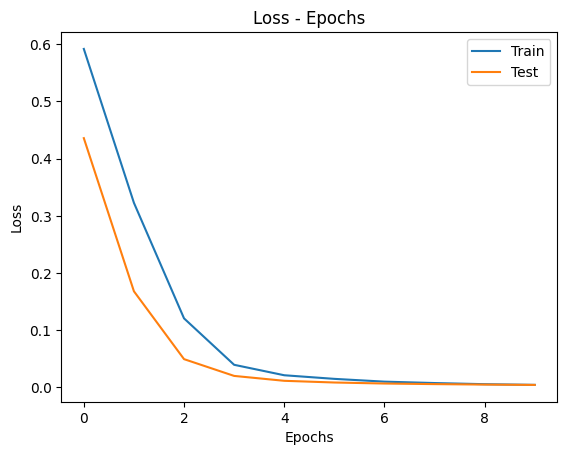

In [31]:
interpreter.train(n_epochs=10)

  0%|          | 0/1498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [02:16, 136.29s/it]              


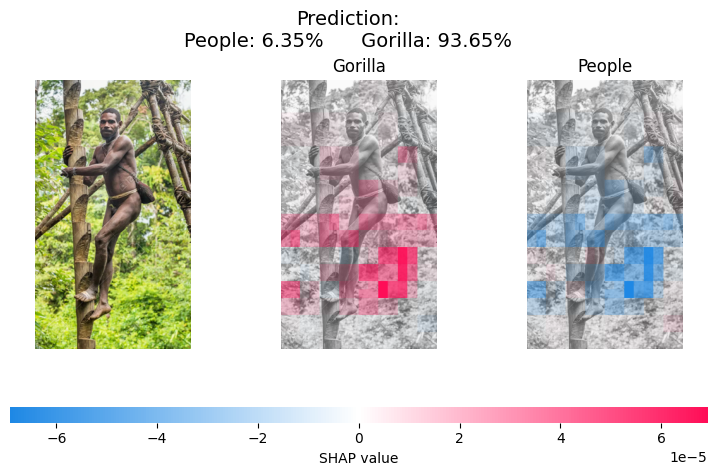

  0%|          | 0/1498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:19, 79.98s/it]               


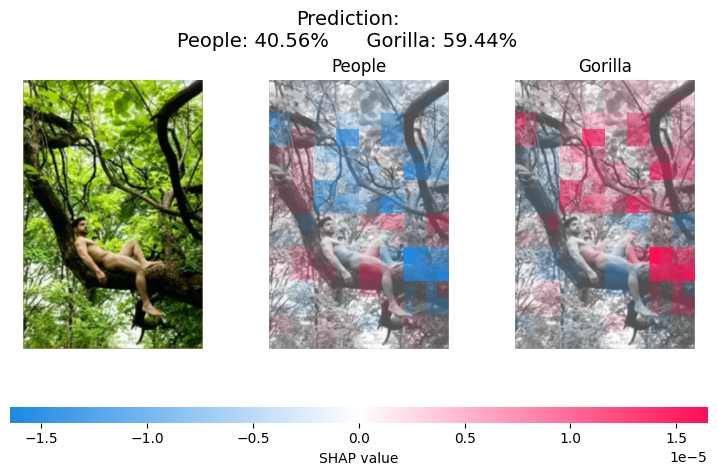

  0%|          | 0/1498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:47, 107.73s/it]              


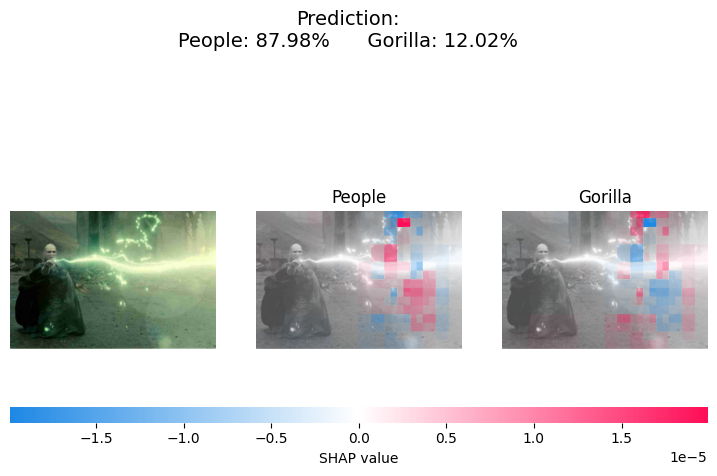

  0%|          | 0/1498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:47, 107.95s/it]              


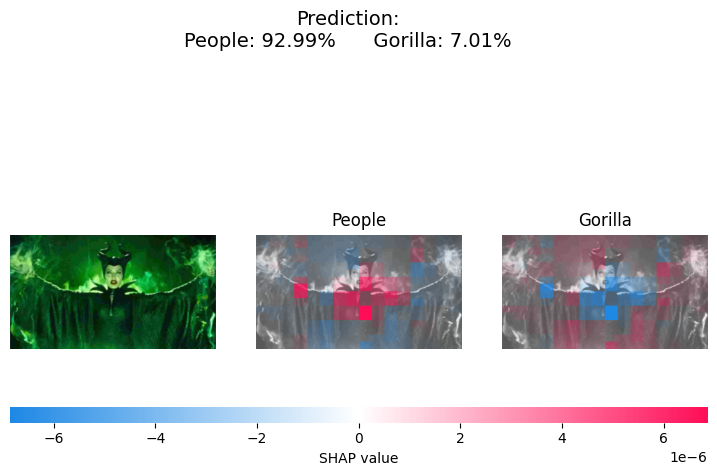

  0%|          | 0/1498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:02, 62.26s/it]               


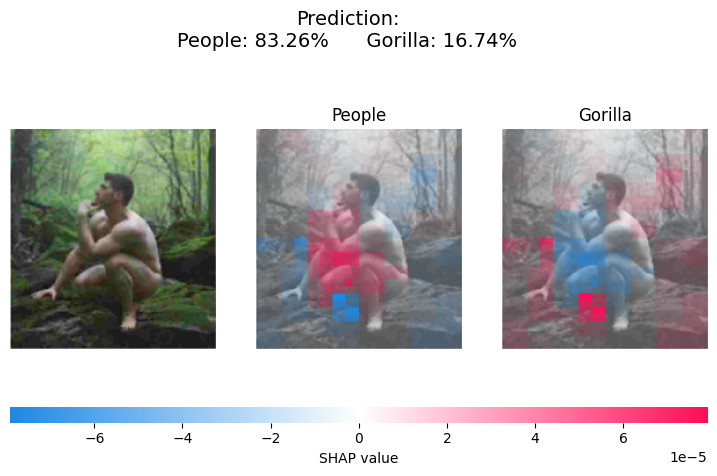

  0%|          | 0/1498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:06, 66.90s/it]               


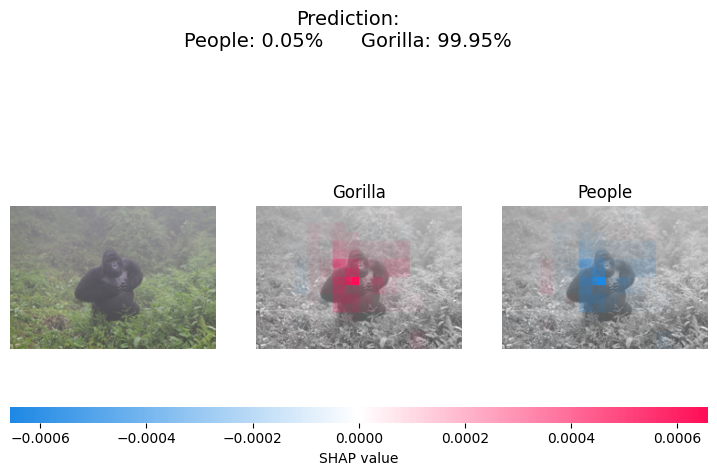

  0%|          | 0/1498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [02:08, 128.46s/it]              


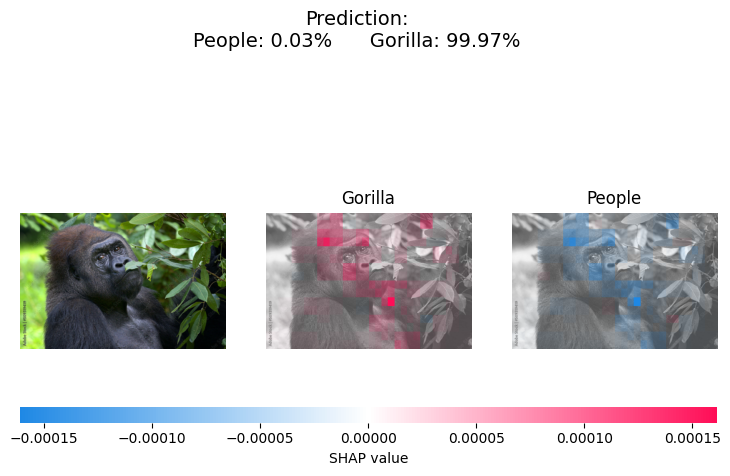

  0%|          | 0/1498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:45, 45.65s/it]               


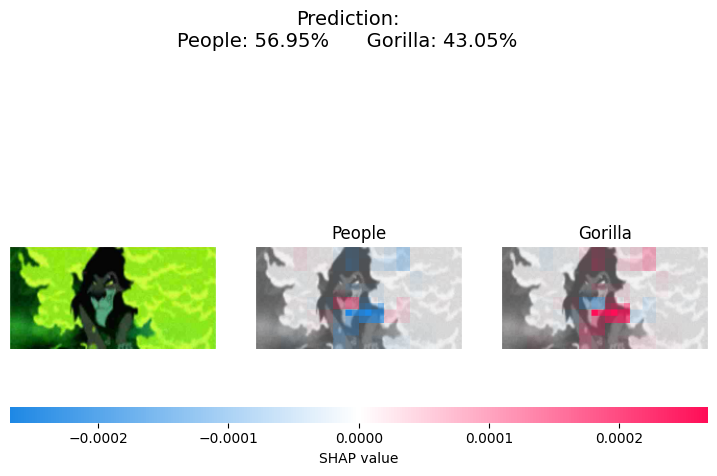

  0%|          | 0/1498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [05:40, 340.05s/it]              


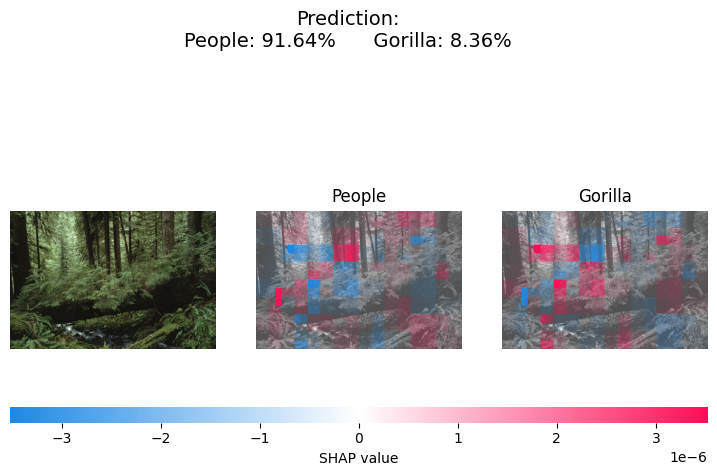

  0%|          | 0/1498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:47, 47.79s/it]               


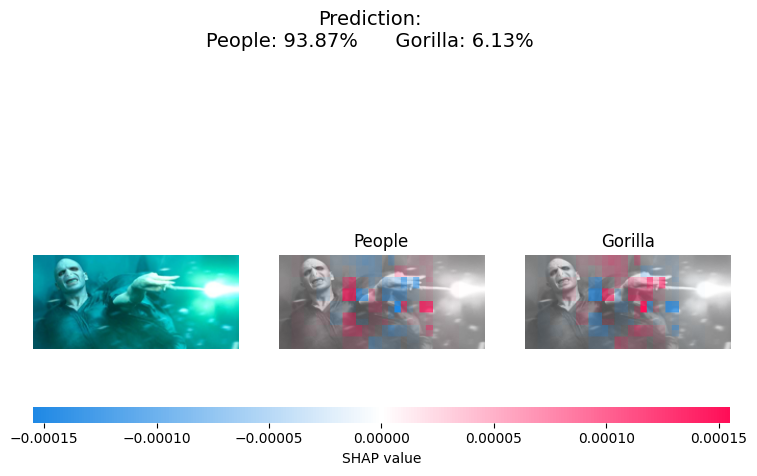

In [33]:
for image_path in os.listdir('Images'):
  interpreter.get_shap_comparative_image(os.path.join('Images', image_path), resize_factor=0.33, max_evals=1500)